# Training the Model

## 1. Imports

In [67]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
from tqdm import tqdm
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd
)


### 1.1 Set Environment Variables for GPU

In [68]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [69]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [70]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,256,256,32))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,256,256,32))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data


#### 2.1.1 Set Training and Validation Transforms

In [71]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1c", "t2", "tmask"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1c", "t2", "tmask"]),
        Orientationd(keys=["t1c", "t2", "tmask"], axcodes="RAS"),        
        EnsureTyped(keys=["t1c", "t2", "tmask"]),
        Resized(keys=["t1c", "t2", "tmask"], spatial_size=(256,256,32)),
        MakeSingleVolumed(keys=["t1c", "t2", "tmask"]),
        Rotate90d(keys=["t1c", "t2", "tmask"]),
        ScaleIntensityd(keys=["t1c", "t2", "tmask"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["t1c", "t2", "tmask"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1c", "t2", "tmask"]),
        Orientationd(keys=["t1c", "t2", "tmask"], axcodes="RAS"),        
        EnsureTyped(keys=["t1c", "t2", "tmask"]),
        Resized(keys=["t1c", "t2", "tmask"], spatial_size=(256,256,32)),
        MakeSingleVolumed(keys=["t1c", "t2", "tmask"]),
        Rotate90d(keys=["t1c", "t2", "tmask"]),
        ScaleIntensityd(keys=["t1c", "t2", "tmask"]),
    ]
)

#### 2.1.2 Test the Transforms


In [72]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

here1
here2
here3
1350 - input_images shape: torch.Size([1, 1, 256, 256, 32])


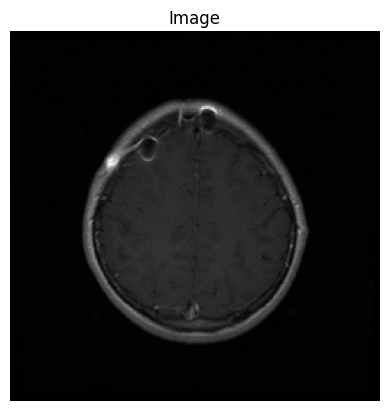

here2
here3
1351 - input_images shape: torch.Size([1, 1, 256, 256, 32])


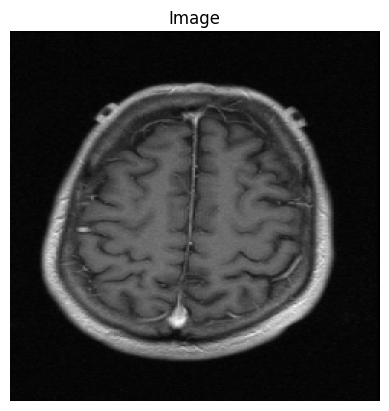

here2
here3
1352 - input_images shape: torch.Size([1, 1, 256, 256, 32])


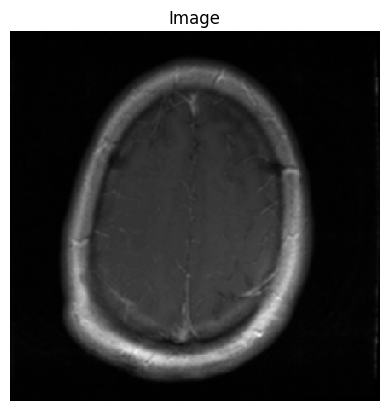

here2
here3
1353 - input_images shape: torch.Size([1, 1, 256, 256, 32])


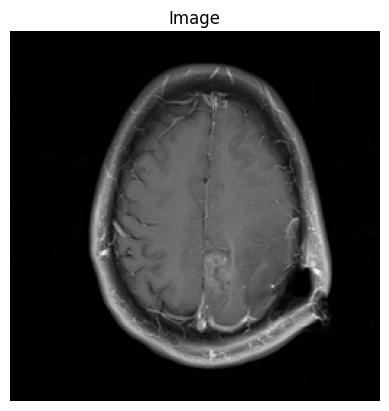

here2
here3
1354 - input_images shape: torch.Size([1, 1, 256, 256, 32])


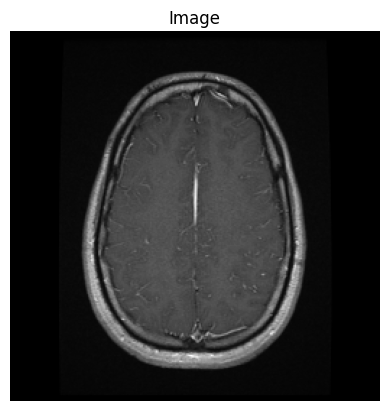

here2
here3
1355 - input_images shape: torch.Size([1, 1, 256, 256, 32])


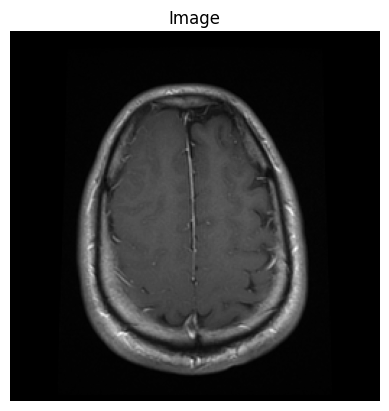

here2
here3
1356 - input_images shape: torch.Size([1, 1, 256, 256, 32])


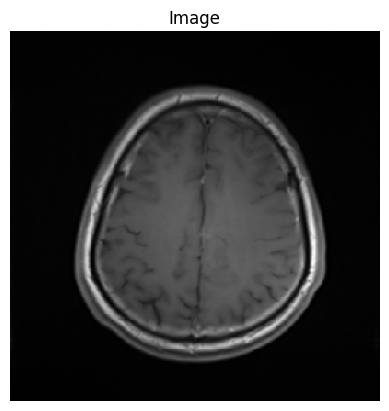

here2
here3
1357 - input_images shape: torch.Size([1, 1, 256, 256, 32])


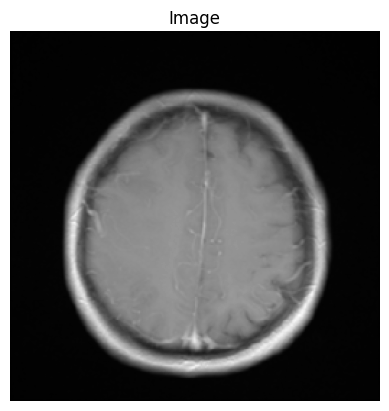

here2
here3
1358 - input_images shape: torch.Size([1, 1, 256, 256, 32])


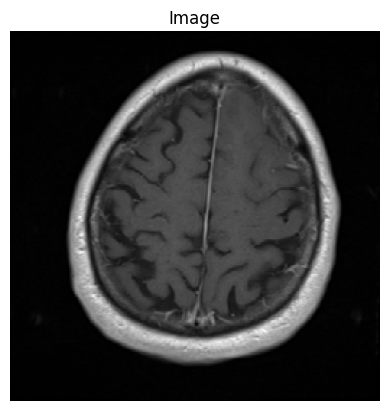

here2
here3
1359 - input_images shape: torch.Size([1, 1, 256, 256, 32])


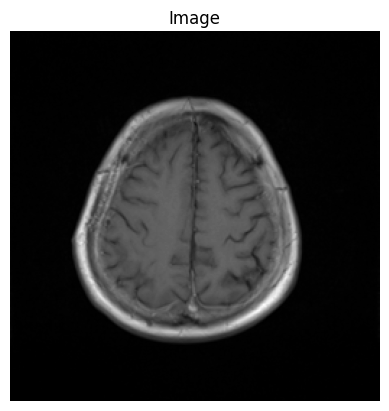

It has been 6.892495155334473 seconds since the loop started


In [73]:
program_starts = time()
step = 1350
print('here1')
for item in check_DataLoader:
    print('here2')
    input_images,  label= item["t1c"], item["MGMT"]
    print('here3')
    if True:
        print(f"{step} - input_images shape: {input_images.shape}")
        plt.title("Image")
        plt.axis('off')
        plt.imshow(np.squeeze(input_images[0,0,:,:,24]), cmap="gray")
        plt.show()
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [74]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|████████████████████████| 105/105 [00:53<00:00,  1.98it/s]


## 3. DenseNet Model (for now)

### 3.1 Model and Device Setup


In [75]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.DenseNet121(
    spatial_dims=3,
    in_channels=3,
    out_channels=1,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

# There's more positive in our train set than negative, so weigh the negative higher in loss function
loss_weights = torch.tensor([0.88]).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)



optimizer = torch.optim.Adam(model.parameters(), 4e-5)

cuda
Let's use 4 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [76]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    x = x[1:]
    y = train_loss
    y = y[1:]
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    x = x[1:]
    y = val_loss
    y = y[1:]
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

----------
epoch 1/20


Epoch : 100%|██████| 27/27 [00:58<00:00,  2.18s/it, Overall Training Loss=0.684]


saved new best metric model
current epoch: 1 current avg accuracy: 0.6667 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
327
train accuracy: 0.5615 validation accuracy: 0.6667 train loss: 0.6461 validation loss 0.6316
----------
epoch 2/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.598]


current epoch: 2 current avg accuracy: 0.6667 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
134
train accuracy: 0.5839 validation accuracy: 0.6667 train loss: 0.6210 validation loss 0.6074
----------
epoch 3/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.606]


current epoch: 3 current avg accuracy: 0.5619 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
130
train accuracy: 0.6265 validation accuracy: 0.5619 train loss: 0.6107 validation loss 0.6522
----------
epoch 4/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.567]


current epoch: 4 current avg accuracy: 0.5238 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
193
train accuracy: 0.6395 validation accuracy: 0.5238 train loss: 0.5931 validation loss 0.6757
----------
epoch 5/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.638]


current epoch: 5 current avg accuracy: 0.6000 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
233
train accuracy: 0.6631 validation accuracy: 0.6000 train loss: 0.5824 validation loss 0.6621


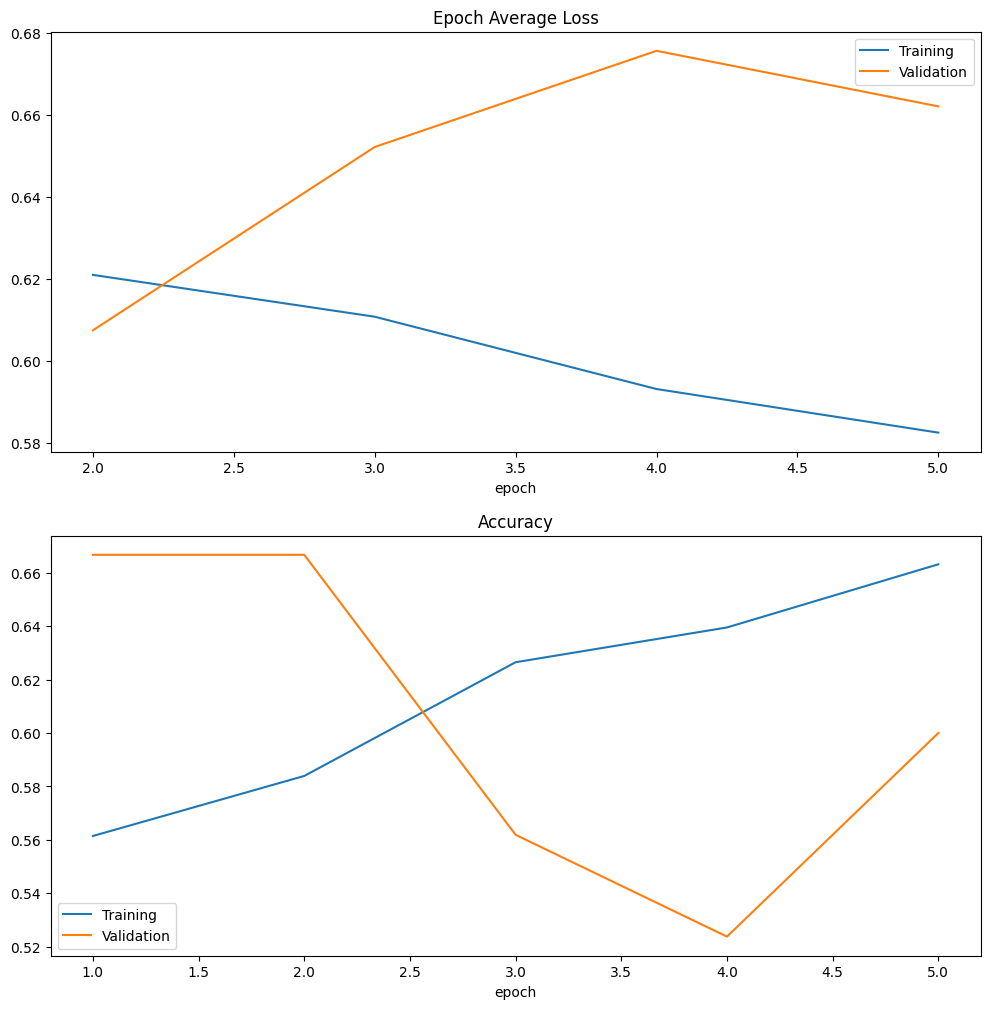

----------
epoch 6/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.90s/it, Overall Training Loss=0.648]


current epoch: 6 current avg accuracy: 0.4857 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
232
train accuracy: 0.6879 validation accuracy: 0.4857 train loss: 0.5673 validation loss 0.8299
----------
epoch 7/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.489]


current epoch: 7 current avg accuracy: 0.5905 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
271
train accuracy: 0.6962 validation accuracy: 0.5905 train loss: 0.5389 validation loss 0.6880
----------
epoch 8/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.466]


current epoch: 8 current avg accuracy: 0.4762 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
302
train accuracy: 0.7423 validation accuracy: 0.4762 train loss: 0.4897 validation loss 0.7939
----------
epoch 9/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.93s/it, Overall Training Loss=0.498]


current epoch: 9 current avg accuracy: 0.6476 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
310
train accuracy: 0.8038 validation accuracy: 0.6476 train loss: 0.4294 validation loss 0.8329
----------
epoch 10/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.408]


current epoch: 10 current avg accuracy: 0.4952 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
337
train accuracy: 0.8215 validation accuracy: 0.4952 train loss: 0.3942 validation loss 1.0036


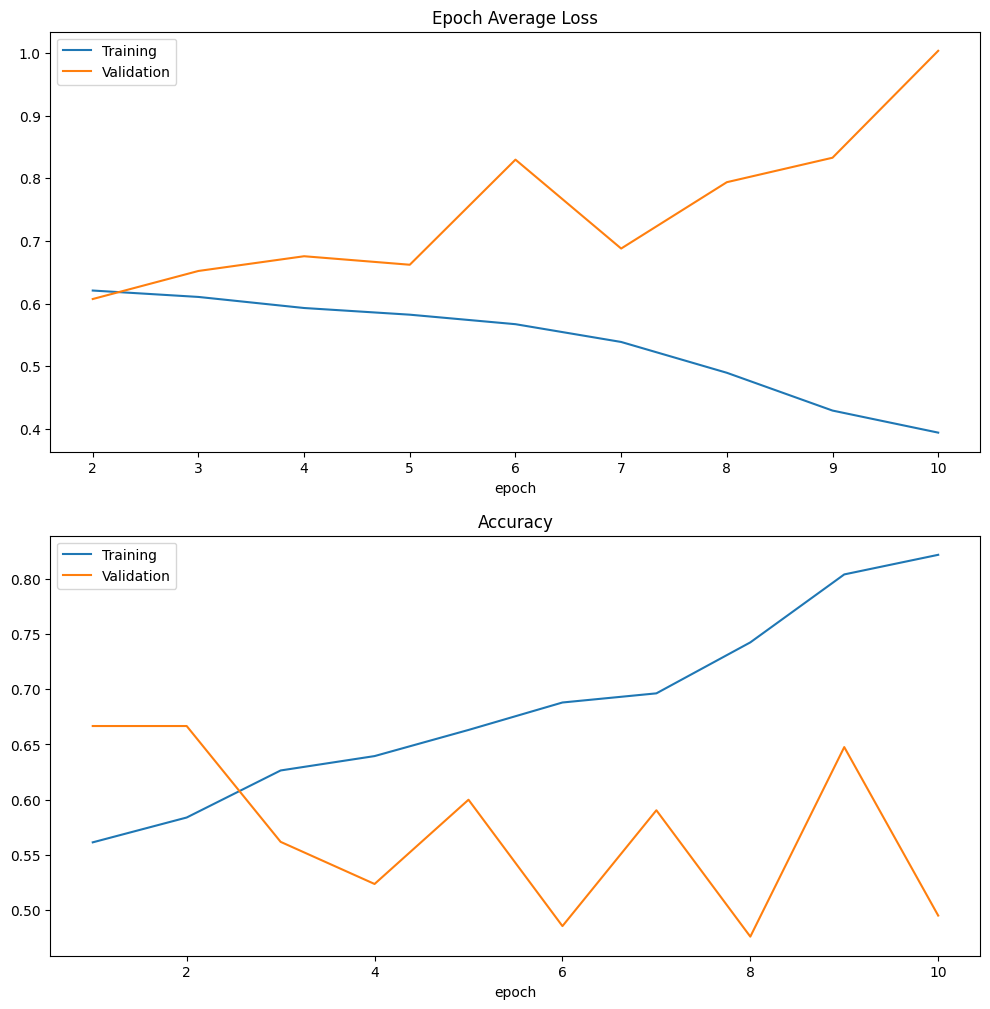

----------
epoch 11/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.333]


current epoch: 11 current avg accuracy: 0.6476 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
341
train accuracy: 0.8428 validation accuracy: 0.6476 train loss: 0.3631 validation loss 1.0647
----------
epoch 12/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.90s/it, Overall Training Loss=0.187]


current epoch: 12 current avg accuracy: 0.5238 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
349
train accuracy: 0.8877 validation accuracy: 0.5238 train loss: 0.2745 validation loss 0.8748
----------
epoch 13/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.92s/it, Overall Training Loss=0.308]


current epoch: 13 current avg accuracy: 0.6286 best accuracy: 0.6667 at epoch 1
Num guessed positive: 
368
train accuracy: 0.9149 validation accuracy: 0.6286 train loss: 0.2270 validation loss 0.7636
----------
epoch 14/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.92s/it, Overall Training Loss=0.509]


saved new best metric model
current epoch: 14 current avg accuracy: 0.6952 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
355
train accuracy: 0.9113 validation accuracy: 0.6952 train loss: 0.2330 validation loss 0.7971
----------
epoch 15/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.194]


current epoch: 15 current avg accuracy: 0.5524 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
359
train accuracy: 0.9137 validation accuracy: 0.5524 train loss: 0.2285 validation loss 1.0338


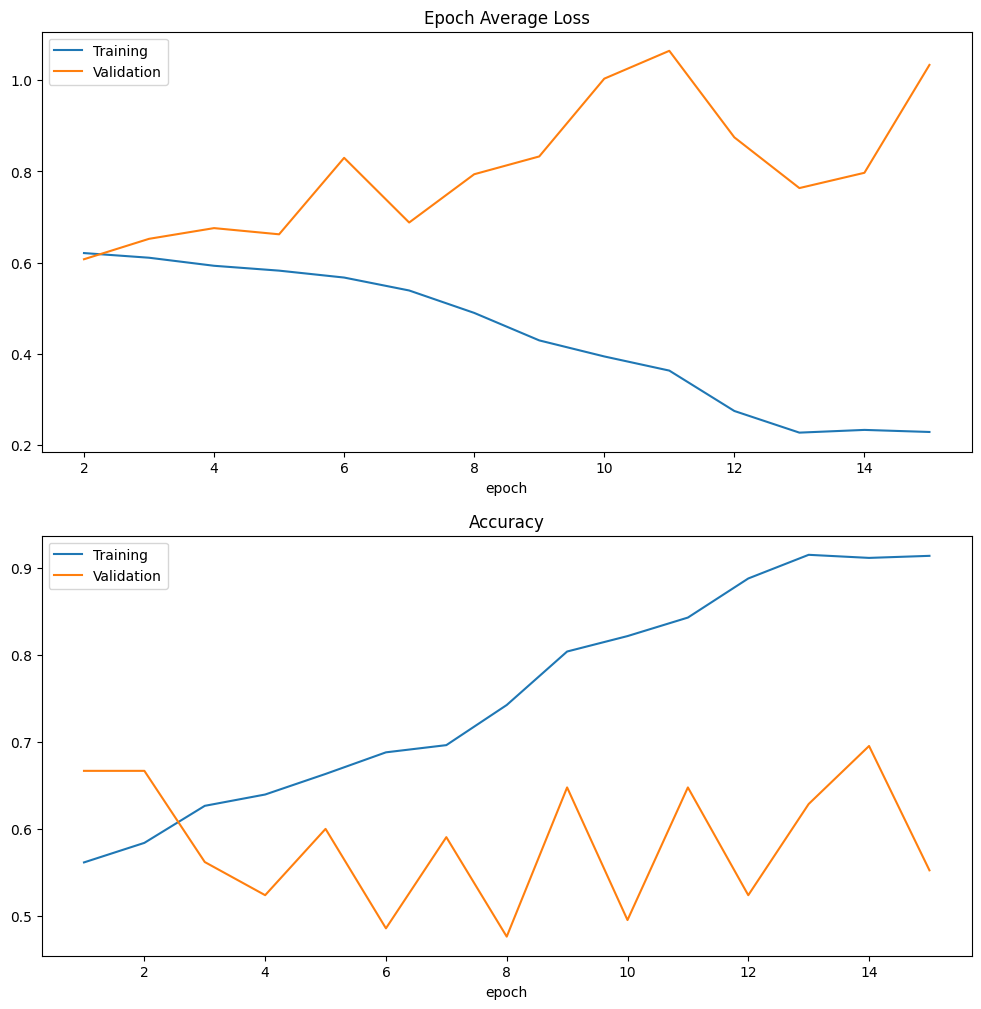

----------
epoch 16/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.424]


current epoch: 16 current avg accuracy: 0.4286 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
368
train accuracy: 0.9362 validation accuracy: 0.4286 train loss: 0.2006 validation loss 1.1252
----------
epoch 17/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.90s/it, Overall Training Loss=0.793]


current epoch: 17 current avg accuracy: 0.6571 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
372
train accuracy: 0.9362 validation accuracy: 0.6571 train loss: 0.1844 validation loss 0.7519
----------
epoch 18/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.90s/it, Overall Training Loss=0.382]


current epoch: 18 current avg accuracy: 0.4762 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
371
train accuracy: 0.9374 validation accuracy: 0.4762 train loss: 0.1835 validation loss 1.6138
----------
epoch 19/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.91s/it, Overall Training Loss=0.242]


current epoch: 19 current avg accuracy: 0.6571 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
371
train accuracy: 0.9397 validation accuracy: 0.6571 train loss: 0.1611 validation loss 0.8070
----------
epoch 20/20


Epoch : 100%|██████| 27/27 [00:51<00:00,  1.90s/it, Overall Training Loss=0.124]


current epoch: 20 current avg accuracy: 0.5429 best accuracy: 0.6952 at epoch 14
Num guessed positive: 
371
train accuracy: 0.9657 validation accuracy: 0.5429 train loss: 0.1264 validation loss 0.9613


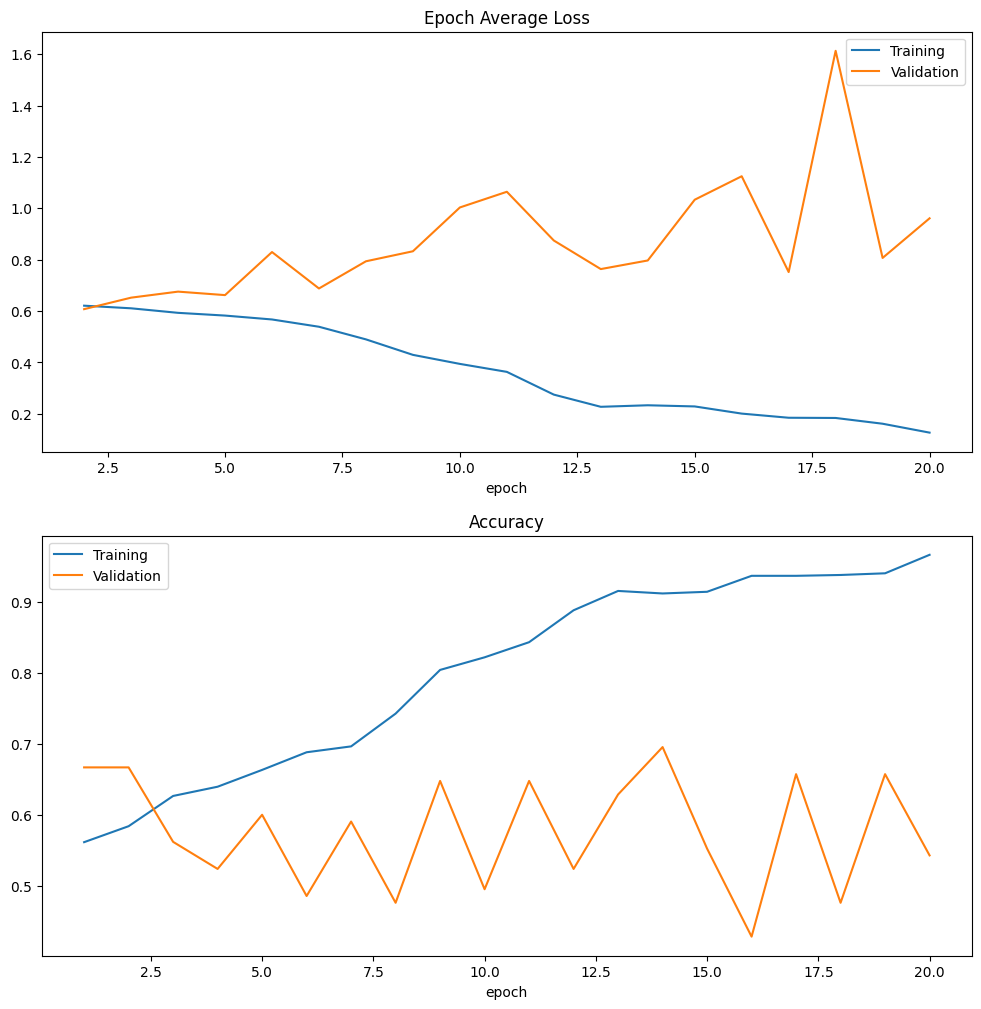

train completed, best_metric: 0.6952 at epoch: 14


In [77]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 20

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    num_correct = 0.0
    metric_count = 0
    num_guessed_positive = 0
    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image = torch.cat((batch_data["t1c"].to(device, dtype=torch.float), batch_data["t2"].to(device, dtype=torch.float), batch_data["tmask"].to(device, dtype=torch.float)), dim = 1) 
            labels = torch.from_numpy(np.asarray(batch_data["MGMT"]).astype('int64')).to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # values for calculating accuracy
            threshold = torch.tensor([0.5]).to(device)
            num_guessed_positive += (torch.sigmoid(output) > threshold).sum().item()
            value = torch.eq((torch.sigmoid(output) > threshold).float()*1, labels)
            metric_count += len(value)
            num_correct += value.sum().item()    
            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_image = torch.cat((val_data["t1c"].to(device, dtype=torch.float), val_data["t2"].to(device, dtype=torch.float), val_data["tmask"].to(device, dtype=torch.float)), dim=1)
                    val_labels =  torch.from_numpy(np.asarray(val_data["MGMT"]).astype('int64')).to(device)
                    output = model(val_image)
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y.float().unsqueeze(1))
                val_loss.append(loss.item())


                
                # calculate and append accuracy
                threshold = torch.tensor([0.5]).to(device)
                acc_value = torch.eq((torch.sigmoid(y_pred) > threshold).float()*1, y.float().unsqueeze(1))
                acc_metric = (acc_value.sum().item()) / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_densenet.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print("Num guessed positive: ")
                print(num_guessed_positive)
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [78]:
torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_densenet.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()
y_true = []
y_pred = []
y_probs = []


with tqdm(test_loader, desc=("Loading ")) as pbar:
    with torch.no_grad():
        for test_data in pbar:
            test_images, test_labels = (
                torch.cat((test_data["t1c"].to(device, dtype=torch.float), test_data["t2"].to(device, dtype=torch.float), test_data["tmask"].to(device, dtype=torch.float)), dim=1), 
                torch.from_numpy(np.asarray(test_data["MGMT"]).astype('int64')).to(device)
            )

            output = torch.sigmoid(model(test_images))
            print(output)
            probs = (output > 0.5)

            y_probs.extend(probs)

            for i in range(len(output)):
                y_true.append(test_labels[i].item())
                y_pred.append(probs[i].item())


Loading :  25%|████████▊                          | 1/4 [00:23<01:09, 23.24s/it]

tensor([[0.2985],
        [0.8349],
        [0.1970],
        [0.2836],
        [0.7572],
        [0.2092],
        [0.1645],
        [0.7376],
        [0.8381],
        [0.0212],
        [0.4396],
        [0.1089],
        [0.0302],
        [0.0974],
        [0.0206],
        [0.9081],
        [0.1073],
        [0.7726],
        [0.5774],
        [0.0325],
        [0.0470],
        [0.7846],
        [0.0923],
        [0.9763],
        [0.7752],
        [0.0239],
        [0.0387],
        [0.2188],
        [0.1968],
        [0.5295],
        [0.0187],
        [0.3113]], device='cuda:0')


Loading :  50%|█████████████████▌                 | 2/4 [00:23<00:19,  9.89s/it]

tensor([[0.0123],
        [0.2919],
        [0.1678],
        [0.0254],
        [0.3708],
        [0.4236],
        [0.0403],
        [0.0251],
        [0.0629],
        [0.0955],
        [0.0654],
        [0.2547],
        [0.5019],
        [0.0723],
        [0.3798],
        [0.8314],
        [0.0478],
        [0.1771],
        [0.7306],
        [0.0490],
        [0.0429],
        [0.8369],
        [0.3382],
        [0.7063],
        [0.6793],
        [0.4815],
        [0.7590],
        [0.3040],
        [0.7353],
        [0.1174],
        [0.0261],
        [0.1215]], device='cuda:0')


Loading :  75%|██████████████████████████▎        | 3/4 [00:24<00:05,  5.62s/it]

tensor([[0.8920],
        [0.1667],
        [0.3981],
        [0.9772],
        [0.0116],
        [0.2257],
        [0.3939],
        [0.0673],
        [0.1298],
        [0.0976],
        [0.2725],
        [0.1565],
        [0.0204],
        [0.0513],
        [0.2768],
        [0.1750],
        [0.1579],
        [0.4382],
        [0.7329],
        [0.5528],
        [0.3993],
        [0.0049],
        [0.8198],
        [0.5725],
        [0.0440],
        [0.7482],
        [0.0358],
        [0.1372],
        [0.0924],
        [0.3171],
        [0.4497],
        [0.1497]], device='cuda:0')


Loading : 100%|███████████████████████████████████| 4/4 [00:24<00:00,  3.56s/it]

tensor([[0.0936],
        [0.9246],
        [0.0129],
        [0.5947],
        [0.0330],
        [0.0441],
        [0.0189],
        [0.1173],
        [0.0113]], device='cuda:0')


Loading : 100%|███████████████████████████████████| 4/4 [00:27<00:00,  6.81s/it]


#### 4.1.2 Classification Report

In [79]:
print(metrics.classification_report(y_true, y_pred, target_names=["UNMETHYLATED", "METHYLATED"], digits=4))

              precision    recall  f1-score   support

UNMETHYLATED     0.5844    0.7377    0.6522        61
  METHYLATED     0.4286    0.2727    0.3333        44

    accuracy                         0.5429       105
   macro avg     0.5065    0.5052    0.4928       105
weighted avg     0.5191    0.5429    0.5186       105



#### 4.1.3 Confusion Matrix

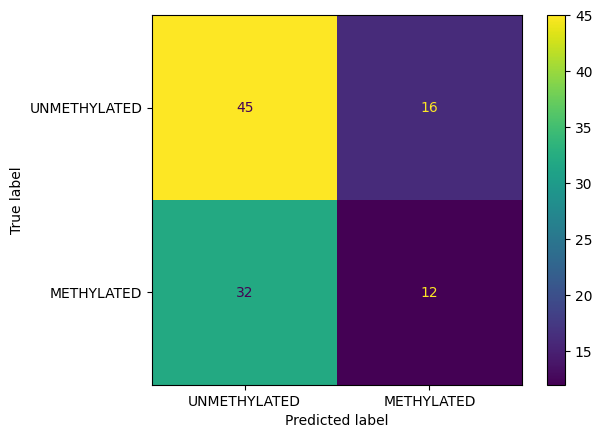

In [80]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [1]:
# What the model is learning from training set doesn't seem to be generalizing to test set

%reset -f